## APS Failure

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE

import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
aps = pd.read_csv('data/aps_training.csv')
aps_test = pd.read_csv('data/aps_test.csv')

In [3]:
aps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   class   object
 1   aa_000  int64 
 2   ab_000  object
 3   ac_000  object
 4   ad_000  object
 5   ae_000  object
 6   af_000  object
 7   ag_000  object
 8   ag_001  object
 9   ag_002  object
 10  ag_003  object
 11  ag_004  object
 12  ag_005  object
 13  ag_006  object
 14  ag_007  object
 15  ag_008  object
 16  ag_009  object
 17  ah_000  object
 18  ai_000  object
 19  aj_000  object
 20  ak_000  object
 21  al_000  object
 22  am_0    object
 23  an_000  object
 24  ao_000  object
 25  ap_000  object
 26  aq_000  object
 27  ar_000  object
 28  as_000  object
 29  at_000  object
 30  au_000  object
 31  av_000  object
 32  ax_000  object
 33  ay_000  object
 34  ay_001  object
 35  ay_002  object
 36  ay_003  object
 37  ay_004  object
 38  ay_005  object
 39  ay_006  object
 40  ay_007  object
 41  ay_008  object
 42  ay_00

In [4]:
aps['ag_000'].value_counts()

0         59133
na          671
2             9
16186         5
4             5
          ...  
193310        1
60334         1
246           1
2514          1
36            1
Name: ag_000, Length: 155, dtype: int64

In [5]:
aps['class'].loc[aps['class'] == 'na']

Series([], Name: class, dtype: object)

In [6]:
aps_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [7]:
aps['class'] = aps['class'].map(lambda x: 0 if x == 'neg' else 1)

In [8]:
aps_test['class'] = aps_test['class'].map(lambda x: 0 if x == 'neg' else 1)

In [9]:
total_na = 0
for c in aps.columns:
    total_na += len(aps[c].loc[aps[c] == 'na'])
total_na

850015

In [10]:
for c in aps.columns:
    aps[c] = aps[c].map(lambda x: np.nan if x == 'na' else x)

In [11]:
for c in aps.columns:
    aps_test[c] = aps_test[c].map(lambda x: np.nan if x == 'na' else x)

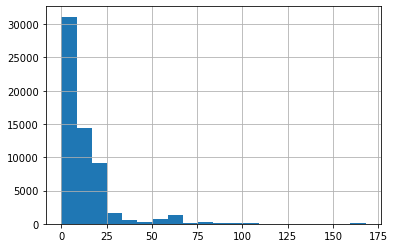

In [12]:
na_in_rows = []
for r in range(len(aps['class'])):
    na_in_rows.append(aps.iloc[r].isna().sum())
pd.Series(na_in_rows).hist(bins=20);

In [13]:
rows_to_drop = []
for r in range(len(aps['class'])):
    if aps.iloc[r].isna().sum() >= 20:
        rows_to_drop.append(r)
aps = aps.drop(index=rows_to_drop)

In [14]:
rows_to_drop = []
for r in range(len(aps_test['class'])):
    if aps_test.iloc[r].isna().sum() >= 20:
        rows_to_drop.append(r)
aps_test = aps_test.drop(index=rows_to_drop)

In [15]:
aps.isna().sum().sum()

372005

In [16]:
aps_test.isna().sum().sum()

98747

In [17]:
len(aps['class'])

45991

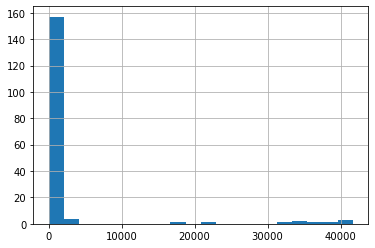

In [18]:
na_in_col = []
for c in aps.columns:
    na_in_col.append(aps[c].isna().sum())
pd.Series(na_in_col).hist(bins=20);

In [19]:
cols_to_drop = []
for c in aps.columns:
    if aps[c].isna().sum() > 5000:
        cols_to_drop.append(c)
aps = aps.drop(columns=cols_to_drop)


In [20]:
aps_test = aps_test.drop(columns=cols_to_drop)

In [21]:
aps.isna().sum().sum()

30982

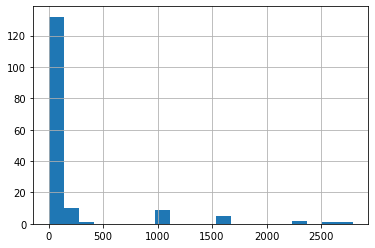

In [22]:
na_in_col = []
for c in aps.columns:
    na_in_col.append(aps[c].isna().sum())
pd.Series(na_in_col).hist(bins=20);

Columns with historgram bins are:  
ag_000 - ag_009 (  7- 16)  
ay_000 - ay_009 ( 33- 42)  
az_000 - az_009 ( 43- 52)  
ba_000 - ba_009 ( 53- 62)  
cn_000 - cn_009 (100-109)  
cs_001 - cs_009 (114-123)  
ee_000 - ee_009 (159-168)  

In [23]:
for i, c in enumerate(aps.columns):
    print(f'{i}: {c}')

0: class
1: aa_000
2: ac_000
3: ad_000
4: ae_000
5: af_000
6: ag_000
7: ag_001
8: ag_002
9: ag_003
10: ag_004
11: ag_005
12: ag_006
13: ag_007
14: ag_008
15: ag_009
16: ah_000
17: ai_000
18: aj_000
19: ak_000
20: al_000
21: am_0
22: an_000
23: ao_000
24: ap_000
25: aq_000
26: ar_000
27: as_000
28: at_000
29: au_000
30: av_000
31: ax_000
32: ay_000
33: ay_001
34: ay_002
35: ay_003
36: ay_004
37: ay_005
38: ay_006
39: ay_007
40: ay_008
41: ay_009
42: az_000
43: az_001
44: az_002
45: az_003
46: az_004
47: az_005
48: az_006
49: az_007
50: az_008
51: az_009
52: ba_000
53: ba_001
54: ba_002
55: ba_003
56: ba_004
57: ba_005
58: ba_006
59: ba_007
60: ba_008
61: ba_009
62: bb_000
63: bc_000
64: bd_000
65: be_000
66: bf_000
67: bg_000
68: bh_000
69: bi_000
70: bj_000
71: bs_000
72: bt_000
73: bu_000
74: bv_000
75: bx_000
76: by_000
77: bz_000
78: ca_000
79: cb_000
80: cc_000
81: cd_000
82: ce_000
83: cf_000
84: cg_000
85: ch_000
86: ci_000
87: cj_000
88: ck_000
89: cl_000
90: cm_000
91: cn_000
9

In [24]:
for c in aps.columns:
    print(aps[c].isna().sum())

0
0
51
1561
0
0
1
1
1
1
1
1
1
1
1
1
22
28
28
272
20
28
20
65
20
65
0
28
28
28
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
22
0
1
0
0
20
20
65
65
41
95
27
27
129
13
0
309
41
130
43
2
1561
1561
1561
11
11
11
2355
2524
0
0
0
0
0
0
0
0
0
0
1561
0
27
0
0
0
0
0
0
0
0
0
0
1106
1106
1106
1106
1106
1106
1106
1106
1106
1
0
148
148
148
148
148
148
148
148
27
0
1
1
2
2
2
2
2
0
0
0
0
148
2792
2355
0
0
0
0
0
0
0
0
0
0
0
0


In [25]:
aps[aps.columns[159:169]].tail(20)

,ef_000,eg_000
59978,0,0
59979,0,0
59980,0,0
59981,0,0
59982,0,0
59983,0,0
59984,0,0
59985,0,0
59987,0,0
59988,0,0


In [26]:
aps[aps.columns[-12:-2]].isna().sum()

ee_000    0
ee_001    0
ee_002    0
ee_003    0
ee_004    0
ee_005    0
ee_006    0
ee_007    0
ee_008    0
ee_009    0
dtype: int64

In [27]:
aps[aps.columns[6:16]].head(20)

,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009
0,0,0,0,0,37250,1432864,3664156,1007684,25896,0
2,0,0,0,0,1648,370592,1883374,292936,12016,0
3,0,0,0,318,2212,3232,1872,0,0,0
4,0,0,0,0,43752,1966618,1800340,131646,4588,0
5,0,0,0,0,9128,701702,1462836,449716,39000,660
7,0,0,0,0,2130,142462,4227340,1674278,59718,876
8,0,0,0,0,458,440704,4398806,2179182,144418,808
9,0,0,0,11804,684444,326536,31586,0,0,0
10,0,0,0,0,4352,713882,1532850,161974,604,0
11,0,0,0,0,2106,418940,2217344,767508,61590,1978


In [28]:
aps[aps.columns[7:17]].isna().sum()

ag_001     1
ag_002     1
ag_003     1
ag_004     1
ag_005     1
ag_006     1
ag_007     1
ag_008     1
ag_009     1
ah_000    22
dtype: int64

In [29]:
na_in_col

[0,
 0,
 51,
 1561,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 22,
 28,
 28,
 272,
 20,
 28,
 20,
 65,
 20,
 65,
 0,
 28,
 28,
 28,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 0,
 1,
 0,
 0,
 20,
 20,
 65,
 65,
 41,
 95,
 27,
 27,
 129,
 13,
 0,
 309,
 41,
 130,
 43,
 2,
 1561,
 1561,
 1561,
 11,
 11,
 11,
 2355,
 2524,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1561,
 0,
 27,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1106,
 1106,
 1106,
 1106,
 1106,
 1106,
 1106,
 1106,
 1106,
 1,
 0,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 148,
 27,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 148,
 2792,
 2355,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [30]:
aps['class'].value_counts()

0    45517
1      474
Name: class, dtype: int64

In [31]:
X_train_imp = pd.read_csv('data/X_train_imp.csv')
y_train = pd.read_csv('data/y_train.csv')

In [32]:
X_test_imp = pd.read_csv('data/X_test_imp.csv')
y_test = pd.read_csv('data/y_test.csv')

In [33]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_imp_sc = scaler.transform(X_train_imp)
X_test_imp_sc = scaler.transform(X_test_imp)

In [37]:
# pipeline = Pipeline()
logreg = LogisticRegression(random_state=2023, class_weight='balanced', max_iter=1000)

In [40]:
logreg.fit(X_train_imp_sc, y_train)

C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2023)

In [42]:
y_preds_imp_sc = logreg.predict(X_test_imp_sc)

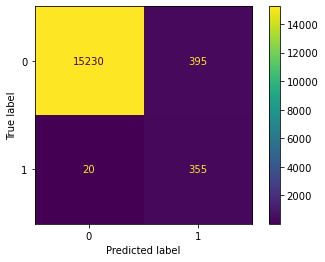

In [49]:
plot_confusion_matrix(logreg, X_test_imp_sc, y_test);

In [44]:
cross_validate(logreg, y_test, y_preds_imp_sc, scoring='recall')

{'fit_time': array([0.00950766, 0.00950813, 0.00950789, 0.00950837, 0.00900745]),
 'score_time': array([0.00150132, 0.00250268, 0.00200129, 0.00150132, 0.00150132]),
 'test_score': array([0.47333333, 0.47333333, 0.48      , 0.49333333, 0.44666667])}

In [36]:
cross_validate(logreg, X_train_imp_sc, y_train, scoring='recall')

C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

{'fit_time': array([0.56948781, 0.62203598, 0.631042  , 0.58900666, 0.62553787]),
 'score_time': array([0.00550461, 0.00550365, 0.00500369, 0.00400305, 0.00450397]),
 'test_score': array([0.95 , 0.885, 0.87 , 0.93 , 0.895])}

In [37]:
cross_validate(logreg, X_test_imp_sc, y_test, scoring='recall')

C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

{'fit_time': array([0.09558344, 0.09408116, 0.09308004, 0.08857656, 0.08707428]),
 'score_time': array([0.00200009, 0.00150132, 0.00200105, 0.00150108, 0.00200224]),
 'test_score': array([0.86666667, 0.86666667, 0.84      , 0.82666667, 0.8       ])}

In [38]:
y_pred_train = logreg.predict(X_train_imp_sc)

In [39]:
recall_score(y_train, y_pred_train)

0.956

In [40]:
y_pred = logreg.predict(X_test_imp_sc)

In [41]:
display(precision_score(y_test, y_pred))
display(recall_score(y_test, y_pred))
display(f1_score(y_test, y_pred))

0.4732620320855615

0.944

0.6304541406945682

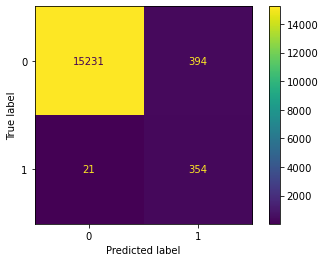

In [42]:
plot_confusion_matrix(logreg, X_test_imp_sc, y_test);

In [43]:
y_pred.sum()

748

In [44]:
dt = DecisionTreeClassifier(random_state=2023)
dt.fit(X_train_imp_sc, y_train)

DecisionTreeClassifier(random_state=2023)

In [45]:
dt.score(X_train_imp_sc, y_train)

1.0

In [46]:
y_pred_dt = dt.predict(X_test_imp_sc)

In [47]:
y_pred_train_dt = dt.predict(X_train_imp_sc)

In [48]:
recall_score(y_train, y_pred_train_dt)

1.0

In [49]:
display(precision_score(y_test, y_pred_dt))
display(recall_score(y_test, y_pred_dt))
display(f1_score(y_test, y_pred_dt))

0.717741935483871

0.712

0.714859437751004

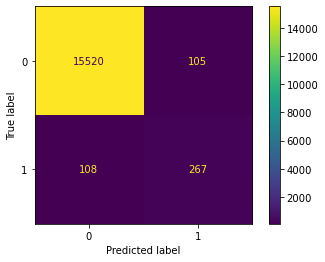

In [50]:
plot_confusion_matrix(dt, X_test_imp_sc, y_test)

In [51]:
sm = SMOTE(random_state=2023, sampling_strategy=0.5)
X_train_imp_sc_sm, y_train_sm = sm.fit_resample(X_train_imp_sc, y_train)

In [52]:
logreg2 = LogisticRegression(random_state=42)
logreg2.fit(X_train_imp_sc_sm, y_train_sm)

C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [56]:
X_aps = aps[aps.columns[1:]]
y_aps = aps['class']

In [57]:
X_aps_test = aps_test[aps_test.columns[1:]]
y_aps_test = aps_test['class']

In [58]:
knnimputer = KNNImputer(n_neighbors=3)
X_aps_imp = pd.DataFrame(knnimputer.fit_transform(X_aps), columns=X_aps.columns)

In [59]:
X_aps_test_imp = pd.DataFrame(knnimputer.fit_transform(X_aps_test), columns=X_aps_test.columns)

In [60]:
logreg3 = LogisticRegression(random_state=2023)
logreg3.fit(X_aps_imp, y_aps)

C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2023)

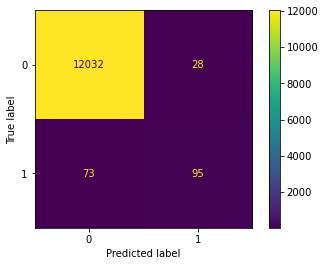

In [63]:
plot_confusion_matrix(logreg3, X_aps_test_imp, y_aps_test)

In [64]:
X_train_imp.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,1.333333,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.000000,0.000000e+00,247.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.000000,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.000000,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [65]:
def remove_na(df):
    for c in df.columns:
        return df[c].map(lambda x: np.nan if x == 'na' else x)
        
def convert_posneg(series):
    return series.map(lambda x: 0 if x == 'neg' else 1)

In [66]:
for c in aps.columns:
    aps[c] = aps[c].map(lambda x: np.nan if x == 'na' else x)
aps['class'] = aps['class'].map(lambda x: 0 if x == 'neg' else 1)

In [67]:
# subpipe_rmna = Pipeline(steps=[])
# subpipe_psng = Pipeline

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
CT = ColumnTransformer()

array([ 1,  5,  9, 13, 17])

In [ ]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__n_estimators'] = np.arange(100, 1100, 100)
params['rfc__max_depth'] = np.arange(1, 51, 1)
params['rfc__min_samples_split'] = np.arange(1, 11, 1)
params['rfc__max_features'] = ['sqrt', 'log2', None]

In [79]:
params = {}
params['criterion'] = ['gini', 'entropy']
# params['n_estimators'] = np.arange(100, 600, 100)
params['max_depth'] = [None] + list(np.arange(1, 101, 10))
params['min_samples_split'] = np.arange(1, 21, 4)
params['max_features'] = ['sqrt', 'log2', None]

In [80]:
rfc = RandomForestClassifier()

In [81]:
gs = GridSearchCV(estimator=rfc, param_grid=params, cv=5, n_jobs=-1, verbose=3, scoring='recall')

In [82]:
gs.fit(X_train_imp, y_train)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 117.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 222.4min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 282.1min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 336.9min
[Parallel(n_jobs=-1)]: Done 1650 out of 1650 | elapsed: 358.3min finished
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 11, 21, 31, 41, 51, 61, 71, 81,
                                       91],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': array([ 1,  5,  9, 13, 17])},
             scoring='recall', verbose=3)

In [83]:
gs.best_estimator_

RandomForestClassifier(max_depth=61, max_features=None, min_samples_split=5)

In [84]:
gs.best_score_

0.713

In [88]:
gs.cv_results_

{'mean_fit_time': array([2.00872564e-01, 5.01947179e+01, 4.95655776e+01, 4.91832494e+01,
        4.72163599e+01, 1.38519049e-01, 2.51734244e+01, 2.52650030e+01,
        2.58510067e+01, 2.70442314e+01, 1.46025419e-01, 9.12792709e+02,
        9.15803495e+02, 8.96173232e+02, 9.05937520e+02, 1.50028753e-01,
        3.44375820e+00, 3.51091609e+00, 3.45186534e+00, 3.82758808e+00,
        1.86560202e-01, 2.29367027e+00, 2.15044723e+00, 2.15304937e+00,
        2.18197417e+00, 1.40320206e-01, 3.66145526e+01, 3.64170828e+01,
        3.57845394e+01, 3.83230204e+01, 1.72047710e-01, 3.29758269e+01,
        3.15112685e+01, 3.03310548e+01, 3.10487715e+01, 1.54532719e-01,
        1.66087673e+01, 1.66335886e+01, 1.72479162e+01, 1.73435985e+01,
        1.35416222e-01, 3.93174545e+02, 4.02072763e+02, 3.93067954e+02,
        3.89381287e+02, 1.40921021e-01, 4.97720554e+01, 5.03727713e+01,
        5.02068290e+01, 5.03676668e+01, 1.79754353e-01, 2.57787444e+01,
        2.65564126e+01, 2.56486326e+01, 2.67267

In [182]:
y_preds_gs_test = gs.predict(X_test_imp)

In [86]:
y_preds_gs = gs.predict(X_train_imp)

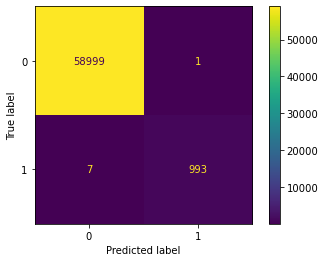

In [87]:
plot_confusion_matrix(gs, X_train_imp, y_train)

In [91]:
cm = confusion_matrix(y_train, y_preds_gs)

In [92]:
cm

array([[58999,     1],
       [    7,   993]], dtype=int64)

In [94]:
cm[1,0], cm[0,1]

(7, 1)

In [209]:
def cost_loss(y, y_pred):
    cm = confusion_matrix(y, y_pred).ravel().tolist()
    return (cm[0]*0) + (cm[1]*10) + (cm[2]*500) + (cm[3]*0)

In [128]:
cost_loss(y_train, y_preds_gs)

3510

In [130]:
custom_cost = make_scorer(cost_loss, greater_is_better=False)

In [114]:
rfc2 = RandomForestClassifier(max_depth=61, min_samples_split=5, max_features=None)

In [115]:
rfc2.fit(X_train_imp, y_train)

<ipython-input-115-29daa31104c4>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(X_train_imp, y_train)


RandomForestClassifier(max_depth=61, max_features=None, min_samples_split=5)

In [116]:
y_preds_rfc2 = rfc2.predict(X_train_imp)

In [117]:
confusion_matrix(y_train, y_preds_rfc2)

array([[58999,     1],
       [   14,   986]], dtype=int64)

In [138]:
cost_loss(y_train, y_preds_rfc2)

7010

In [113]:
confusion_matrix(y_train, y_preds_gs)

array([[58999,     1],
       [    7,   993]], dtype=int64)

In [139]:
cost_loss(y_train, y_preds_gs)

3510

In [121]:
params2 = {}
params2['max_depth'] = [60, 61, 62]
params2['max_features'] = [None]
params2['min_samples_split'] = [4, 5, 6]

In [122]:
gs2 = GridSearchCV(estimator=rfc2, param_grid=params2, cv=5, n_jobs=-2, verbose=3, scoring=cost_scorer)

In [123]:
gs2.fit(X_train_imp, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-2)]: Done  40 out of  45 | elapsed: 55.0min remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed: 64.7min finished
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=61, max_features=None,
                                              min_samples_split=5),
             n_jobs=-2,
             param_grid={'max_depth': [60, 61, 62], 'max_features': [None],
                         'min_samples_split': [4, 5, 6]},
             scoring=make_scorer(cost_loss, greater_is_better=False),
             verbose=3)

In [145]:
gs2.best_estimator_

RandomForestClassifier(max_depth=62, max_features=None, min_samples_split=4)

In [146]:
gs2.cv_results_

{'mean_fit_time': array([844.86455655, 839.23752279, 834.2154089 , 820.51233773,
        818.44175911, 814.89210958, 807.33571863, 801.52022314,
        769.75853934]),
 'std_fit_time': array([12.15444579, 20.48218122, 15.24897677, 16.3645281 , 15.99797453,
         8.31353987, 14.72638123, 16.79923248, 67.57428524]),
 'mean_score_time': array([0.15123   , 0.15393229, 0.15153017, 0.15443263, 0.1520308 ,
        0.14832745, 0.14462428, 0.13191328, 0.10589099]),
 'std_score_time': array([0.00177366, 0.00505017, 0.0041192 , 0.00650628, 0.00759845,
        0.00652187, 0.00279517, 0.01502822, 0.00353278]),
 'param_max_depth': masked_array(data=[60, 60, 60, 61, 61, 61, 62, 62, 62],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[None, None, None, None, None, None, None, None, None],
              mask=[False, False, False, False, False, False, 

In [126]:
gs2.best_score_

-28598.0

In [141]:
y_preds_gs2 = gs2.predict(X_train_imp)

In [142]:
confusion_matrix(y_train, y_preds_gs2)

array([[59000,     0],
       [    4,   996]], dtype=int64)

In [143]:
cost_loss(y_train, y_preds_gs2)

2000

In [188]:
gboost = xgboost.XGBClassifier(tree_method='gpu_hist')

In [189]:
gboost.fit(X_train_imp_sc, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [190]:
xgb_preds = gboost.predict(X_train_imp_sc)

In [191]:
cost_loss(y_train, xgb_preds)

0

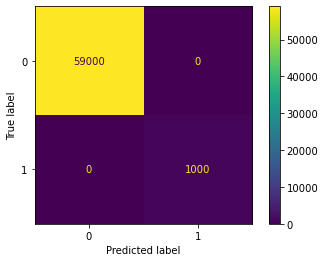

In [176]:
plot_confusion_matrix(gboost, X_train_imp_sc, y_train);

In [250]:
xgb = xgboost.XGBClassifier(n_estimators=100, tree_method='gpu_hist')

In [251]:
params_xg = {"colsample_bytree": [0.3, 0.5, 0.8],
             "reg_alpha": [0, 0.5, 1, 5],
             "reg_lambda": [0, 0.5, 1, 5],
             "max_depth": [5, 10, 15, 20, 25, 30]}

In [252]:
gs3 = GridSearchCV(estimator=xgb, param_grid=params_xg, cv=10, n_jobs=-1, verbose=3, scoring='recall')

In [ ]:
gs3.fit(X_train_imp_sc, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.3min


In [248]:
gs3.best_score_

0.765

In [241]:
y_preds_gs3 = gs3.predict(X_train_imp_sc)

In [242]:
cost_loss(y_train, y_preds_gs3)

0

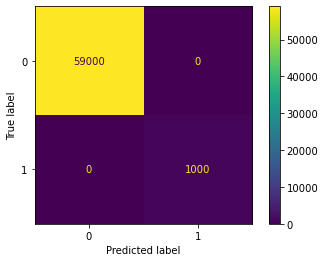

In [243]:
plot_confusion_matrix(gs3, X_train_imp_sc, y_train)